In [228]:
import pandas as pd
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, svm 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

style.use('ggplot')

df = quandl.get('WIKI/GOOGL')

print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

In [229]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df_copy = df.copy()
df_copy['HL_PCT'] = (df_copy['Adj. High'] - df_copy['Adj. Close']) / df_copy['Adj. Close'] * 100.0
df_copy['PCT_change'] = (df_copy['Adj. Close'] - df_copy['Adj. Open']) / df_copy['Adj. Open'] * 100.0
df_copy = df_copy[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close' 

In [230]:
print(df.tail())

            Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume
Date                                                               
2018-03-21    1092.57    1108.70   1087.21     1094.00    1990515.0
2018-03-22    1080.01    1083.92   1049.64     1053.15    3418154.0
2018-03-23    1051.37    1066.78   1024.87     1026.55    2413517.0
2018-03-26    1050.60    1059.27   1010.58     1054.09    3272409.0
2018-03-27    1063.90    1064.54    997.62     1006.94    2940957.0


In [231]:
df_copy.fillna(-88888, inplace=True)
forecast_out = int(math.ceil(0.01*len(df)))
df_copy['label'] = df[forecast_col].shift(-forecast_out)
df_copy

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0,69.078238
2004-08-20,54.322689,0.710922,7.227007,22834300.0,67.839414
2004-08-23,54.869377,3.729433,-1.227880,18256100.0,68.912727
2004-08-24,52.597363,6.417469,-5.726357,15247300.0,70.668146
2004-08-25,53.164113,1.886792,1.183658,9188600.0,71.219849
...,...,...,...,...,...
2018-03-21,1094.000000,1.343693,0.130884,1990515.0,NaN
2018-03-22,1053.150000,2.921711,-2.487014,3418154.0,NaN
2018-03-23,1026.550000,3.918952,-2.360729,2413517.0,NaN


In [232]:
X = np.array(df_copy.drop(['label'], axis=1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]


y = np.array(df_copy['label'])
             

df_copy.dropna(inplace=True)
y = np.array(df_copy['label'])


In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = LinearRegression()
clf.fit(X_train, y_train)

with open('linearregression.pickle', 'wb') as f: 
    pickle.dump(clf, f)
    
pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

accuracy = clf.score(X_test, y_test)
print(accuracy)

0.9780455897649111


In [234]:
forecast_set = clf.predict(X_lately)

In [235]:
print(forecast_set, accuracy, forecast_out)

[1104.35573669 1073.97214935 1021.24028364 1062.50168757 1074.38713669
 1074.72220296 1093.51043817 1112.55734185 1115.94391412 1124.1906668
 1133.6213106  1130.63214011 1150.03492006 1165.71432943 1137.32886735
 1123.60278122 1089.45942152 1104.8077785  1115.78348992 1122.38471977
 1136.5931047  1151.11556622 1182.74082714 1187.15145891 1159.18241444
 1170.04312534 1171.89149538 1154.49516644 1119.78176852 1116.22371467
 1114.27878396 1071.33184963 1044.00906342 1074.13608094 1022.73603663] 0.9780455897649111 35


In [236]:
df_copy['Forecast'] = np.nan

In [237]:
last_date = df_copy.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day


In [238]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df_copy.loc[next_date] = [np.nan for _ in range(len(df_copy.columns)-1)] + [i]

In [239]:
df_copy

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label,Forecast
Date,,,,,,
2004-08-19 00:00:00,50.322842,3.712563,0.324968,44659000.0,69.078238,NaN
2004-08-20 00:00:00,54.322689,0.710922,7.227007,22834300.0,67.839414,NaN
2004-08-23 00:00:00,54.869377,3.729433,-1.227880,18256100.0,68.912727,NaN
2004-08-24 00:00:00,52.597363,6.417469,-5.726357,15247300.0,70.668146,NaN
2004-08-25 00:00:00,53.164113,1.886792,1.183658,9188600.0,71.219849,NaN
...,...,...,...,...,...,...
2018-03-07 19:00:00,NaN,NaN,NaN,NaN,NaN,1114.278784
2018-03-08 19:00:00,NaN,NaN,NaN,NaN,NaN,1071.331850
2018-03-09 19:00:00,NaN,NaN,NaN,NaN,NaN,1044.009063


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


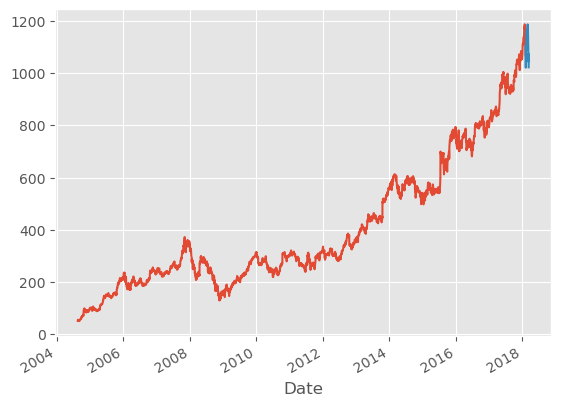

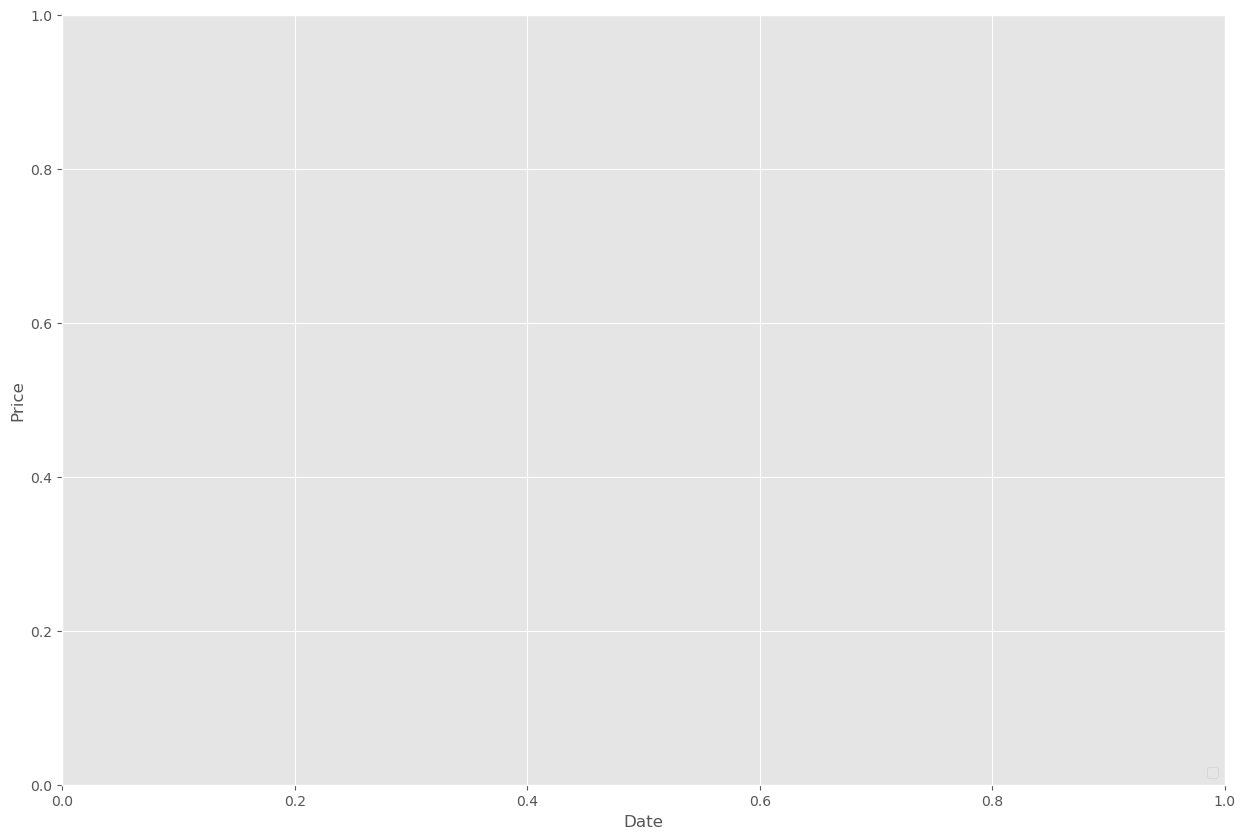

In [241]:
df_copy['Adj. Close'].plot()
df_copy['Forecast'].plot()
plt.figure(figsize=(15, 10))
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()